In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

output_dir = 'output/'
metadata_file = 'data/metadata.csv'
annotations_file = 'data/annotations.pkl'

## Parameters for the concept map
*min_concept_occurrence*: # of times a concept needs to occur in a textbook to be considered
*textbook_parts*: # of equal parts the textbook is divided into for binning

In [2]:
min_concept_occurrence = 50
textbook_parts = 50
max_edge_pct_distance = 0.08

## Load metadata

In [3]:
metadata = pd.read_csv(metadata_file, dtype = {'ISBN': 'str'})

## Load annotations

In [4]:
def extract_spotlight_concept_and_location(annotation):
    return annotation['URI'].split('/resource/')[-1], annotation['offset']

isbns = metadata['ISBN']

with open(annotations_file, 'rb') as fp:
    annotations = pickle.load(fp) 

## Extract concepts

In [5]:
concepts_df = pd.DataFrame()
for isbn in isbns:
    concepts = [extract_spotlight_concept_and_location(ann) 
                for ann in annotations[isbn]]
    concept, loc = zip(*concepts)
    max_loc = max(loc)
    concepts_df = concepts_df.append(
        pd.DataFrame({
                      'concept': concept,
                      'location': [lll / max_loc for lll in loc],
                      'ISBN': isbn
                    }))         

In [6]:
summary_df = (concepts_df
              .groupby('ISBN')['concept']
              .agg({'count', lambda x: len(set(x))}))
summary_df = summary_df.reset_index()
summary_df.columns = ['ISBN', 'count' ,'unique_concepts']

metadata = pd.merge(summary_df, metadata, on = 'ISBN')
metadata

,ISBN,count,unique_concepts,title,author,subject,imprint,sold_by,start_page,end_page
0,9781429219617,41787,4383,BIOLOGY OF PLANTS,PETER H RAVEN,BIOLOGY,FREEMAN/WORTH,Macmillan Higher Education,21,747
1,9781429242301,10084,2516,INTRODUCING PSYCHOLOGY,DANIEL L SCHACTER,PSYCHOLOGY,FREEMAN/WORTH,Macmillan Higher Education,38,526
2,9781429298643,76427,7083,LIFE: THE SCIENCE OF BIOLOGY,DAVID E SADAVA,BIOLOGY,FREEMAN/WORTH,Macmillan Higher Education,51,1297
3,9781429298902,7970,1432,PSYCHOLOGY: A CONCISE INTRODUCTION,RICHARD A GRIGGS,PSYCHOLOGY,WORTH PUBLISHERS,Macmillan Higher Education,22,464
4,9781464126147,54360,3733,MOLECULAR BIOLOGY: PRINCIPLES AND PRACTICE,MICHAEL M COX,BIOLOGY,W. H. FREEMAN,Macmillan Higher Education,30,828
5,9781464135958,23537,2733,WHAT IS LIFE? A GUIDE TO BIOLOGY,JAY PHELAN,BIOLOGY,FREEMAN/WORTH,Macmillan Higher Education,34,718
6,9781464140815,14470,3723,PSYCHOLOGY,DAVID G MYERS,PSYCHOLOGY,FREEMAN/WORTH,Macmillan Higher Education,59,751
7,9781464154072,13578,3414,EXPLORING PSYCHOLOGY,DAVID G MYERS,PSYCHOLOGY,WORTH PUBLISHERS,Macmillan Higher Education,59,662
8,9781464171703,15505,3294,ABNORMAL PSYCHOLOGY,RONALD J COMER,PSYCHOLOGY,WORTH PUBLISHERS,Macmillan Higher Education,33,699


## Top Concepts

In [7]:
concept_count_df = concepts_df.groupby(['concept', 'ISBN'])['location'].count().reset_index()
concept_count_df.columns = ['concept', 'ISBN', 'count']
concept_count_df = concept_count_df.sort_values('count', ascending=False)

concept_count_df = concept_count_df[concept_count_df['count'] >= min_concept_occurrence]
concepts_keep = set(concept_count_df['concept'].values)

concepts_df = concepts_df[concepts_df['concept'].map(lambda x: x in concepts_keep)]

## Bin the location of each concept's occurrence

In [8]:
location_splits = [r / textbook_parts for r in range(textbook_parts)]
concepts_df['location_bin'] = np.digitize(concepts_df['location'], location_splits)

In [9]:
concept_locations = (concepts_df
                     .groupby(['location_bin', 'ISBN', 'concept'])
                     .count()
                     .reset_index()
                     .rename(columns={'location': 'count'}))

concept_location_matrices = {isbn:
                            (concept_locations
                             .query("ISBN==@isbn")
                             .pivot(index='location_bin',
                                    columns='concept',
                                    values='count')
                             .fillna(0))
                            for isbn in isbns}

## Build location metrics for each concept
Here we are summarizing where the concept first occurs in the book and where it occurs the most often.

In [10]:
def location_metrics(x):
    max_count = x['count'].max()
    total_count = x['count'].sum()
    
    all_locs = []
    for loc, count in zip(x['location_bin'], x['count']):
        all_locs.extend([loc] * count)
        
    first_quartile = all_locs[int(len(all_locs) / 4)]
          
    metrics = {
        'total_count': total_count,
        'first_quartile_bin': first_quartile,
        'common_bin': x.query('count == @max_count')['location_bin'].min()
    }
    return pd.Series(metrics)

concept_bins = (concept_locations
                .groupby(['ISBN', 'concept'])
                .apply(location_metrics)                
                .query('total_count >= @min_concept_occurrence')
                .sort_values('common_bin')
                .reset_index())

## Find the distance between concepts in each book
Negative numbers indicate a concept occurs first

In [11]:
def create_distance_dataframe(concept_bin):
    bin_types = ['common_bin', 'first_quartile_bin']
    full_df = pd.DataFrame()
    for bin_type in bin_types:
        vec = concept_bin[bin_type]
        mat = np.repeat(vec[np.newaxis, :], len(vec), axis=0)
        # Positive means the concept occurs first
        distance_mat = (mat - mat.T) / textbook_parts
        concept2 = concept_bin['concept'].values
        distance_df = pd.DataFrame(distance_mat, 
                                   index=concept_bin['concept'],
                                   columns=concept2)

        distance_df = distance_df.stack().reset_index()
        distance_df.columns = ['concept', 'concept2', 'distance_{}'.format(bin_type)]
        if len(full_df) == 0:
            full_df = distance_df
        else:
            full_df = pd.merge(full_df, distance_df, on=['concept', 'concept2'])
        
    full_df = full_df[full_df['concept'] != full_df['concept2']]
    
    full_df = pd.merge(full_df, 
                       (concept_bin[['ISBN', 'concept', 'total_count']]
                        .rename(columns={'total_count': 'count'})), 
                        on='concept')
    full_df = pd.merge(full_df, 
                       (concept_bin[['concept', 'total_count']]
                        .rename(columns={'concept': 'concept2', 'total_count': 'count2'})), 
                        on='concept2')

    full_df['cooccurrence'] = full_df[['count', 'count2']].min(axis=1)
    return full_df

distance_df = pd.concat([
    create_distance_dataframe(concept_bins.query('ISBN==@isbn')) 
        for isbn in isbns
])

## Combine the distance metrics across books

In [12]:
def distance_summary_metrics(x):
    count = x['cooccurrence'].sum()
    titles = len(x['ISBN'].unique())
    metrics = {
        'n_titles': titles,
        'total_count': count,
        'distance_common': (x['distance_common_bin'] *
                            x['cooccurrence']).sum() / count,
        'distance_first_quartile': (x['distance_first_quartile_bin'] *
                                    x['cooccurrence']).sum() / count
    }
    return pd.Series(metrics)

distance_summary = (distance_df
                    .groupby(['concept', 'concept2'])
                    .apply(distance_summary_metrics)
                    .reset_index())

In [13]:
distance_filtered = (distance_summary
                     .query('distance_first_quartile >= 0 & '
                            'distance_first_quartile <= @max_edge_pct_distance'))

print('Total concepts: {}'.format(len(distance_filtered['concept'].unique())))

(distance_filtered
 .sort_values('total_count', ascending=False)
 .head(10)
 .style.format({'distance_common': "{:.2f}",
                'distance_first_quartile': "{:.2f}"}))

Total concepts: 478


## Create directed graph from this list of concept pairs

In [14]:
G = nx.from_pandas_dataframe(distance_filtered,
                             source='concept',
                             target='concept2',
                             edge_attr=['distance_common',
                                        'distance_first_quartile',
                                        'total_count',
                                        'n_titles'],
                             create_using=nx.DiGraph())

## Plot a sample concept's related nodes

In [15]:
concept = 'Gene'

pre_concepts = nx.DiGraph([(n, u) for n, u in G.edges() if u == concept])
post_concepts = nx.DiGraph([(n, u) for n, u in G.edges() if n == concept])

### Prerequisites

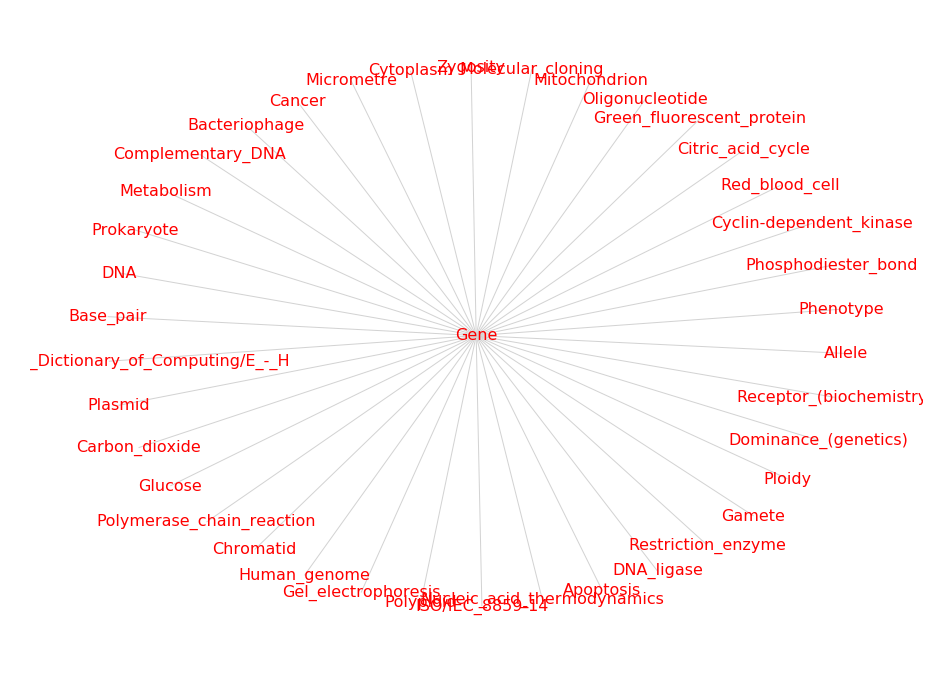

In [16]:
plt.figure(figsize=(16,12))
limits=plt.axis('off')

pos = nx.spring_layout(pre_concepts)
# nx.draw_networkx_nodes(pre_concepts, pos)
nx.draw_networkx_edges(pre_concepts, pos, arrows=False, edge_color='lightgrey')
nx.draw_networkx_labels(pre_concepts, pos, font_color='red', font_size=16)

plt.show()

### Postrequisites

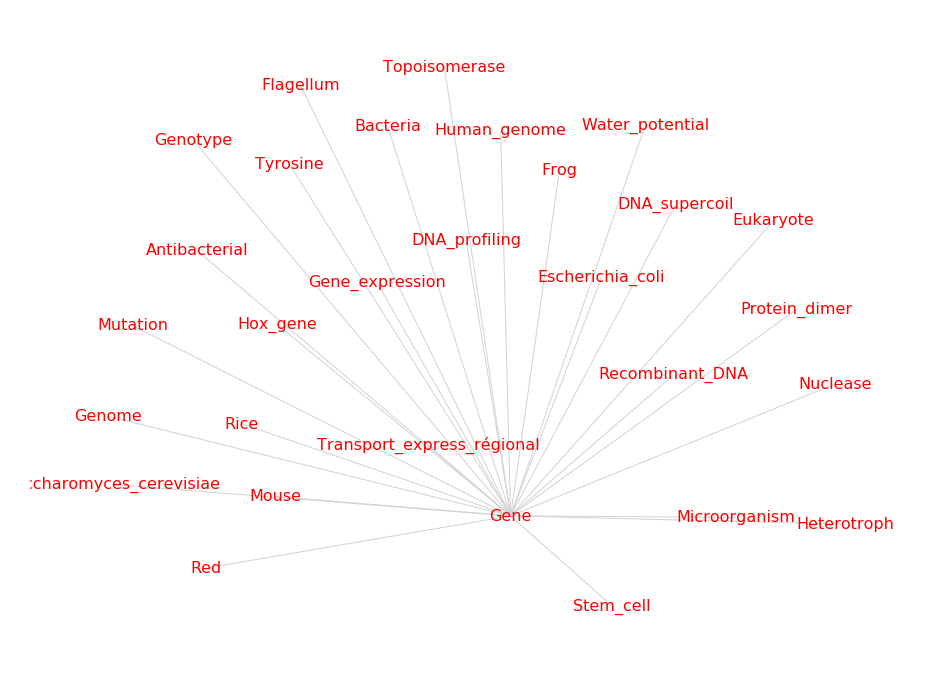

In [17]:
plt.figure(figsize=(16,12))
limits=plt.axis('off')

pos = nx.spring_layout(post_concepts)
# nx.draw_networkx_nodes(post_concepts, pos)
nx.draw_networkx_edges(post_concepts, pos, arrows=False, edge_color='lightgrey')
nx.draw_networkx_labels(post_concepts, pos, font_color='red', font_size=16)

plt.show()